In [1]:
# python inbuilt-libraires
from typing import Tuple, List, Dict
from functools import partial
from collections import defaultdict

# torch
import torch
from torch import nn
from torch import utils as torch_utils


# numpy
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib widget


# Utility

## Add the function to class

In [2]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class,obj.__name__,obj)
    return wrapper

## Base class for the dataloaders


In [3]:
class DataModule:
    def get_dataloader(self, train: bool):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)


## Base Class for Model


In [4]:
class Module(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, x: torch.Tensor):
        assert hasattr(self, "net")
        return self.net(x)

    def configure_optimizer(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def training_step(self, batch):
        X,y = batch
        # forward pass
        y_logits = self(X)
        loss = self.loss(y_logits,y)
        return y_logits,loss

    def validation_step(self, batch):
        X,y = batch
        # forward pass
        y_logits = self(X)
        loss = self.loss(y_logits,y)
        return y_logits,loss


## Animate class

In [5]:
class Animate:
    def __init__(self):
        self.fig = plt.figure(figsize=(4,3),layout="constrained")
        self.ax = plt.axes(xlim=(0, 3.5), ylim=(0, 10))
        self.train_loss_line, = self.ax.plot([], [],"o-",markevery=[-1], lw=2,label="train_loss")
        self.val_loss_line, = self.ax.plot([], [],"o-",markevery=[-1], lw=2,label="test_loss")
        self.ax.set_xlabel("epochs")
        self.ax.set_ylabel("Loss")
        self.ax.set_title("Loss Curve")
        plt.legend()

    def update(self, i):
        # print(f"[INFO] Entering Animate Update")
        self.trainer.fit_epoch()
        # print(f"[INFO] Finished {i} epoch")
        # print(self.trainer.history["train_loss"])
        self.ax.set_xlim(0, self.trainer.max_epochs)
        self.ax.set_ylim(
            min(self.trainer.history["train_loss"]) - 1,
            max(self.trainer.history["train_loss"]) + 1,
        )
        self.train_loss_line.set_data(
            list(range(len(self.trainer.history["train_loss"]))),
            self.trainer.history["train_loss"],
        )
        self.val_loss_line.set_data(
            list(range(len(self.trainer.history["val_loss"]))),
            self.trainer.history["val_loss"],
        )
        return self.train_loss_line,self.val_loss_line

    def ani_init(self):
        self.train_loss_line.set_data([], [])
        return self.train_loss_line

    def animate(self,save:bool=False):
        # print("[INFO] Entering Aimate ")
        # print(hasattr(self, "trainer"))
        assert hasattr(self, "trainer"), "Plot is not prepared"
        self.anim = animation.FuncAnimation(
            fig=self.fig,
            func=self.update,
            init_func=self.ani_init,
            frames=self.trainer.max_epochs,
            repeat=False,
            blit=True,
        )
        if save:
            print("Saving the animation")
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=5, bitrate=1800)
            self.anim.save(f'{self.trainer.model.__class__.__name__}.mp4', writer=writer)

## Trainer class

In [6]:
class Trainer:
    def __init__(self, max_epochs,show_ani=False,save_ani=False) -> None:
        self.max_epochs = max_epochs
        self.save_ani = save_ani
        self.show_ani = show_ani
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def prepare_data(self, data: DataModule):
        # print("[INFO] Entering Data Prerparaion")
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (
            len(self.val_dataloader) if self.val_dataloader is not None else 0
        )

    def prepare_model(self,model:Module):
        # print("[INFO] Entering Model Preparartion")
        model.trainer = self
        self.model = model.to(self.device)
        
    
    def prepare_batch(self,batch):
        batch = [a.to(self.device) for a in batch]
        return batch
    
    def prepare_plot(self):
        # print("[INFO] Entering Plot Preparation")
        self.ani_plot = Animate()
        self.ani_plot.trainer = self
        
    
    def fit(self,model:Module,data:DataModule):
        # print("[INFO] Entering FIT")
        self.prepare_data(data=data)
        self.prepare_model(model)
        self.prepare_plot()
        self.optim = model.configure_optimizer()
        # all the training and animation is happening here
        # to store the history 
        self.history = defaultdict(list)
        if self.show_ani:
            self.ani_plot.animate(self.save_ani)
        else:
            for epoch in range(self.max_epochs):
                self.fit_epoch()
            self.ani_plot.train_loss_line.set_data(list(range(self.max_epochs)),self.history["train_loss"])
            self.ani_plot.val_loss_line.set_data(list(range(self.max_epochs)),self.history["val_loss"])
            plt.show()
            

    
    def fit_epoch(self):       
        # do the training step
        self.train_step()
        if self.val_dataloader is None:
            return
        # do the val step
        self.val_step()

    
    def train_step(self):
        # print("[INFO] Entered into the training step")
        batch_loss = 0
        # put the model in training mode
        self.model.train()
        # Loop through the train dataloader
        for batch in self.train_dataloader:
            # do forward and find the loss
            y_logits,loss = self.model.training_step(self.prepare_batch(batch))
            batch_loss += loss
            # set the zero grad
            self.optim.zero_grad()
            with torch.no_grad():
                # back propagate the loss
                loss.backward()
                self.optim.step()
        avg_batch_loss = batch_loss / self.num_train_batches
        self.history["train_loss"].append(avg_batch_loss.cpu().item())
    
    def val_step(self):
        # put the model in eval mode
        batch_loss = 0 
        self.model.eval()
        # Loop through the val dataloader
        for batch in self.val_dataloader:
            with torch.inference_mode():
                y_logits , loss = self.model.validation_step(self.prepare_batch(batch))
                batch_loss += loss
        avg_batch_loss = batch_loss / self.num_train_batches
        self.history["val_loss"].append(avg_batch_loss.cpu().item())

# Linear Regression from Scratch:

## Define the Model

In [7]:
class LinearRegressionScratch(Module):
    def __init__(self,num_inputs,lr,sigma=0.01) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        self.lr = lr
        self.sigma = sigma
        self.w = torch.normal(mean=0,std=sigma,size=(num_inputs,1),requires_grad=True)
        self.b = torch.zeros(1,requires_grad=True)
    
    def forward(self, x: torch.Tensor):
        return torch.matmul(x,self.w)+self.b

    
    def loss(self, y_hat, y):
        l = (y_hat - y)**2 /2
        return l.mean()

## Define the optimization Algorithm

In [8]:
class SGD:
    def __init__(self,params,lr) -> None:
        self.params = params
        self.lr = lr
    
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [9]:
# the optimizer the linear regression class
@add_to_class(LinearRegressionScratch)
def configure_optimizer(self):
    return SGD([self.w,self.b],self.lr)

## Create the SyntheticData

In [10]:
class SyntheticRegressionData(DataModule):
    def __init__(
        self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32
    ) -> None:
        self.w = w
        self.b = b
        self.noise = noise
        self.num_train = num_train
        self.num_val = num_val
        self.batch_size = batch_size

        n = num_train + num_val
        self.X = torch.randn(size=(n, len(self.w)))
        noise = torch.randn(size=(n, 1)) * self.noise
        self.y = torch.matmul(self.X, torch.reshape(self.w, (-1, 1))) + b

    def get_dataloader(self, train: bool):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X,self.y),train,i)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset=dataset,batch_size=self.batch_size,shuffle=True)


## Train the model

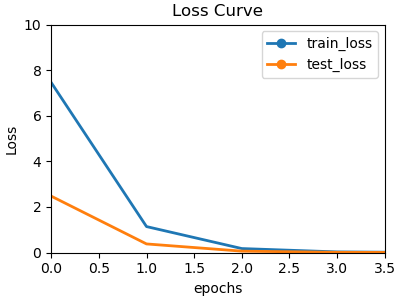

In [12]:
model = LinearRegressionScratch(num_inputs=2,lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2,-3.4]),b=4.2)
trainer = Trainer(max_epochs=10,show_ani=False)
trainer.fit(model=model,data=data)